# Main Aggregation Script

In [13]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
from sqlite3 import Connection as SQLite3Connection
from sqlalchemy import create_engine, event, select
from sqlalchemy.engine import Engine
from sqlalchemy.orm import sessionmaker
import base
from ipas import lab_ice_agg_SQL as lab
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from dask import delayed
import cloudpickle as pickle
from multiprocessing import Pool
from functools import partial
import time

In [10]:
cluster = SLURMCluster(
    queue='batch',
    walltime='04-23:00:00',
    cores=1,
    memory='7168MiB', #1 GiB = 1,024 MiB
    processes=1)


cluster.scale(5)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [11]:
client = Client(cluster)


In [12]:
client

Client Scheduler: tcp://169.226.65.81:40099 Dashboard: http://169.226.65.81:8787/status,Cluster Workers: 5 Cores: 5 Memory: 37.60 GB


In [2]:
phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
#phioarr = phioarr[1:]
lenphio = len(phioarr)

reqarr = [800,900, 1000]
#reqarr = [50]
numaspectratios=len(phioarr)
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
nclusters = 300        #changes how many aggregates per aspect ratio to consider
ncrystals = 50       #number of monomers per aggregate 1
minor = 'depth'        #'minorxy' from fit ellipse or 'depth' to mimic IPAS in IDL
rand_orient = True    #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     #saves all histograms to path with # of aggs and minor/depth folder
file_ext = 'eps'


In [3]:
def main():

    '''
    for phio in phioarr:
        for r in reqarr:
            b3 = lab.collect_clusters(session, phio, r, nclusters=nclusters,
                                ncrystals=ncrystals, rand_orient=rand_orient, lodge=0)     
    
    '''
    
        #trying to write in parallel:
#     def commit_obj_todb(r, b3):
#         engine = create_engine('sqlite:///IPAS_'+r+'_lastmono.sqlite')
#         event.listen(engine, 'connect', _set_sqlite_pragma)
#         ipas.base.Base.metadata.create_all(engine, checkfirst=True)
#         Session = sessionmaker(bind=engine)
#         session = Session()
#         try:
            
#             for obj in b3:
#                 session.add_all(obj)  # crystal id has been appended into cluster relationship
#                 session.commit()

#         except:
#             print('in except')
#             raise
#         session.close() 
#         print('DONE!')

    notebook=6
    for r in reqarr:
        #b3 = []
        print('r = ',r)
        count = 1
        pool = Pool(processes=20) #pools are reusable
        parallel_clus=partial(lab.collect_clusters, notebook=notebook, r=r, nclusters=nclusters,\
                                ncrystals=ncrystals, \
                                rand_orient=rand_orient)

        start = time.time()
        output = pool.imap_unordered(parallel_clus, phioarr)
        for done in output:
            print("after %3.1fsec: count:%s"%(time.time()-start, count))
            count +=1

#         for res in output:
#             print("(after %3.1fsec)  mono phi:%.3f  count:%s"%(time.time()-start, res[0].mono_phi, count))
#             count += 1
        print('closing')
        pool.close()
        print('joining')
        pool.join()
        print('new r')

        #b3.append([x for x in output])
              
        #write to db in parallel (to diff files based on r)
        #parallel_commit = partial(commit_obj_todb, b3=b3)
        #output = pool.imap_unordered(parallel_commit, r)
        
 
    '''

    output = []
    for r in reqarr:
        for phio in phioarr:
    
            print('eq. vol rad', r, phio)

            output.append(delayed(lab.collect_clusters)(phio, r, nclusters=nclusters,
                                                        ncrystals=ncrystals, rand_orient=rand_orient))
            
    
    print(output)
    print('computing...')
    b3 = client.compute(output) 
    b3 = client.gather(b3)
    '''
    
    #return b3
    

r =  800
nclus 800 61.584821106602604 0
nclus 800 0.026366508987303583 0
nclus 800 0.016237767391887217 0
nclus 800 0.06951927961775606 0
nclus 800 100.0 0
nclus 800 0.04281332398719394 0
nclus 800 0.01 0
nclus 800 0.7847599703514611 0
nclus 800 14.38449888287663 0
nclus 800 3.359818286283781 0
nclus 800 0.4832930238571752 0
nclus 800 8.858667904100823 0
nclus 800 37.92690190732246 0
nclus 800 0.11288378916846889 0
nclus 800 0.29763514416313175 0
nclus 800 5.455594781168514 0
nclus 800 2.06913808111479 0
nclus 800 0.18329807108324356 0
nclus 800 1.2742749857031335 0
nclus 800 23.357214690901213 0
nclus 800 0.18329807108324356 50
nclus 800 0.04281332398719394 50
nclus 800 0.06951927961775606 50
nclus 800 0.7847599703514611 50
nclus 800 0.29763514416313175 50
nclus 800 0.01 50
nclus 800 0.016237767391887217 50
nclus 800 0.026366508987303583 50
nclus 800 0.11288378916846889 50
nclus 800 0.4832930238571752 50
nclus 800 3.359818286283781 50
nclus 800 5.455594781168514 50
nclus 800 2.0691380

/network/rit/lab/sulialab/share/IPAS_3radii/ipas/ice_cluster_aggagg_SQL.py:1417: RuntimeWarning: invalid value encountered in sqrt
  semimajor = np.sqrt(evals[0]) * 2


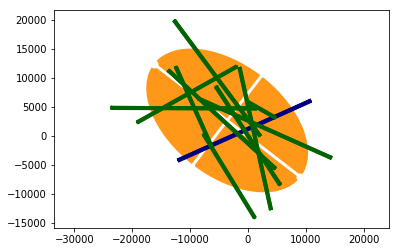

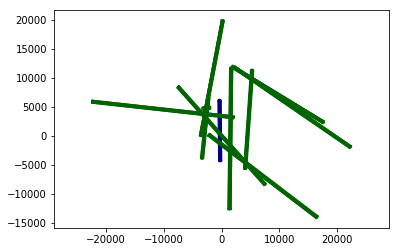

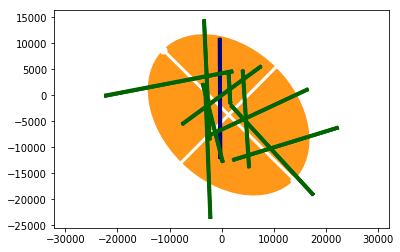

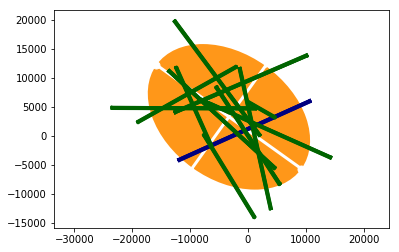

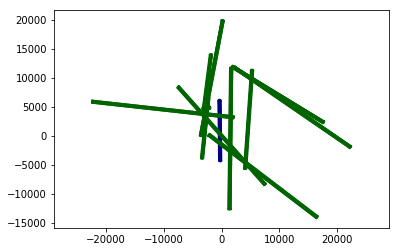

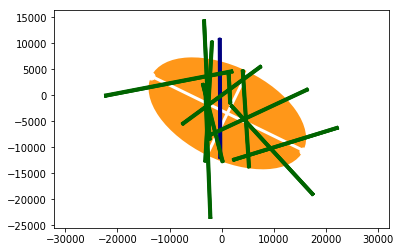

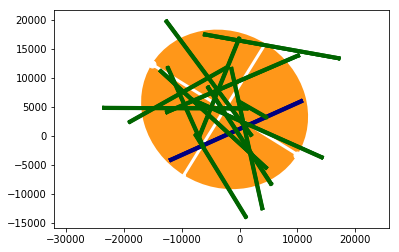

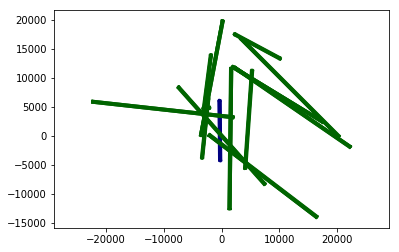

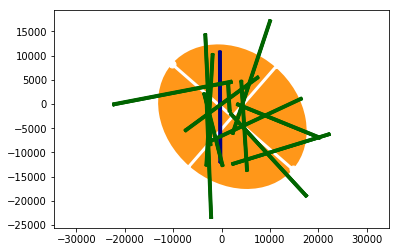

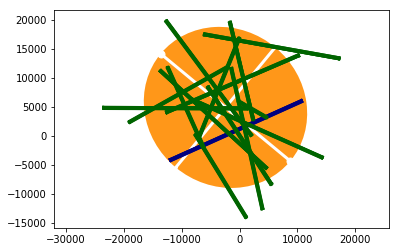

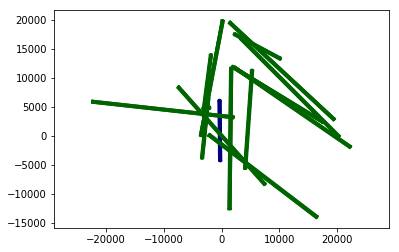

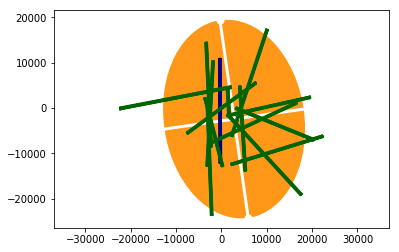

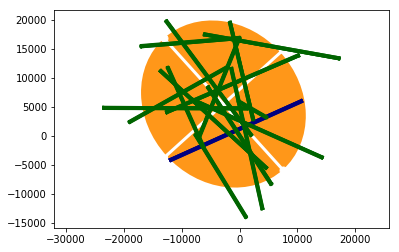

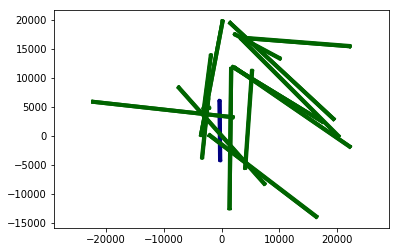

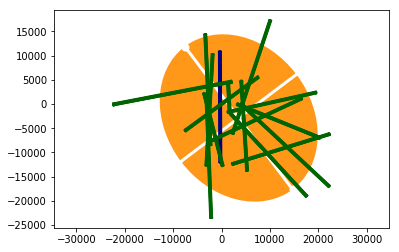

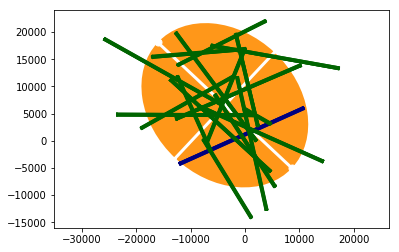

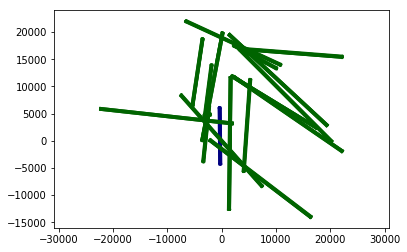

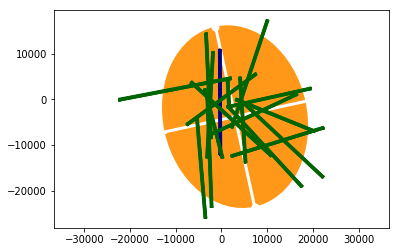

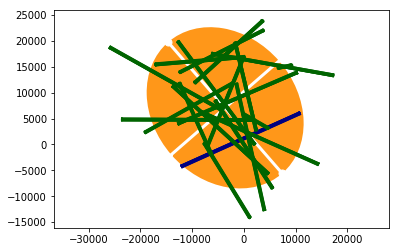

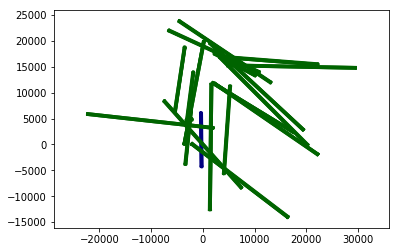

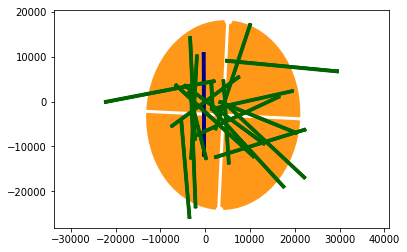

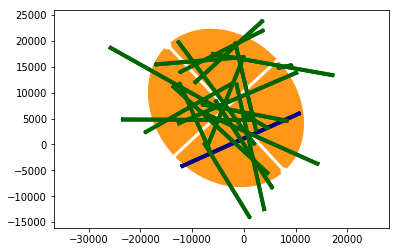

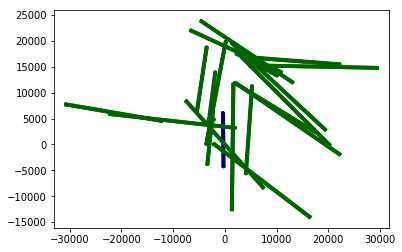

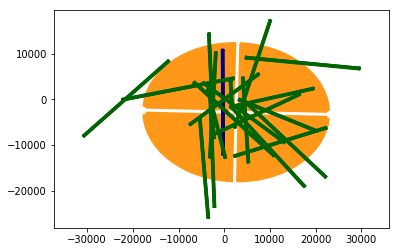

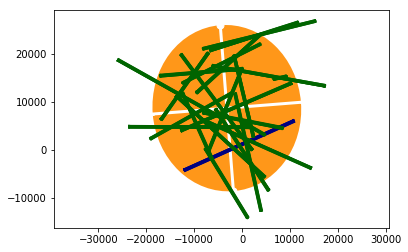

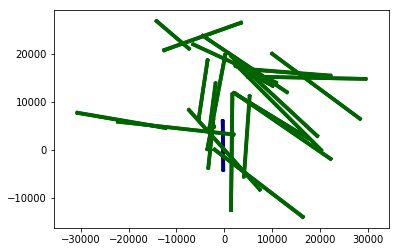

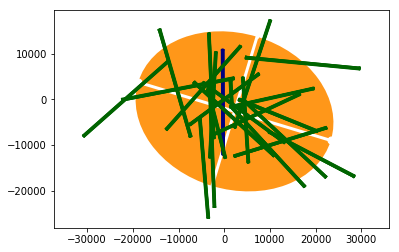

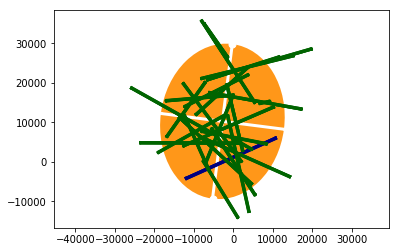

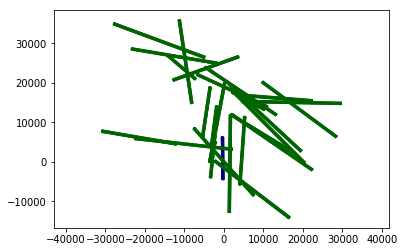

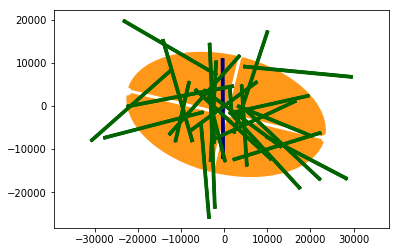

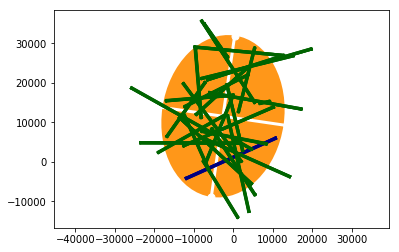

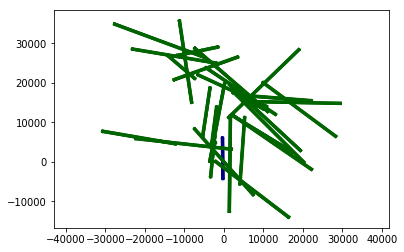

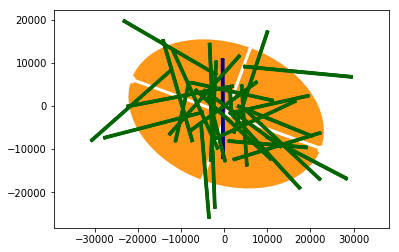

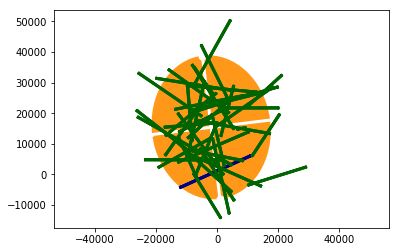

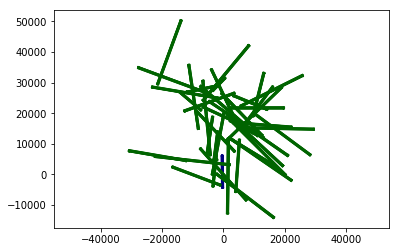

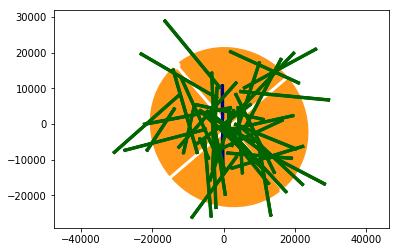

nclus 800 61.584821106602604 250
done committing phio = 37.927
after 35172.6sec: count:18
nclus 800 100.0 250
done committing phio = 61.585
after 36675.3sec: count:19
done committing phio = 100.000
after 37897.1sec: count:20
closing
joining
new r
r =  900
nclus 900 100.0 0
nclus 900 37.92690190732246 0
nclus 900 5.455594781168514 0
nclus 900 2.06913808111479 0
nclus 900 0.29763514416313175 0
nclus 900 61.584821106602604 0
nclus 900 23.357214690901213 0
nclus 900 0.18329807108324356 0
nclus 900 14.38449888287663 0
nclus 900 0.016237767391887217 0
nclus 900 0.7847599703514611 0
nclus 900 8.858667904100823 0
nclus 900 0.04281332398719394 0
nclus 900 0.11288378916846889 0
nclus 900 0.01 0
nclus 900 1.2742749857031335 0
nclus 900 3.359818286283781 0
nclus 900 0.06951927961775606 0
nclus 900 0.4832930238571752 0
nclus 900 0.026366508987303583 0
nclus 900 0.18329807108324356 50
nclus 900 0.11288378916846889 50
nclus 900 0.016237767391887217 50
nclus 900 0.4832930238571752 50
nclus 900 0.04281

In [ ]:
if __name__ == '__main__':

    %time main() 
        
#     filename = 'instance_3radii_iceagg_allrand_50xtalstot_20phi_rall_300agg_3_lastmono'
#     filehandler = open(filename, 'wb')
#     %time pickle.dump(b3, filehandler)
#     filehandler.close()
#     print('finished, creating engine 3!')
    

In [9]:
engine = create_engine('sqlite:///IPAS_3_23.357_lastmono.sqlite')
ipas.base.Base.metadata.create_all(engine, checkfirst=True)
Session = sessionmaker(bind=engine)
session = Session()

In [12]:
print('AGGREGATE PROPERTIES ==============')

query = session.query(ipas.IceCluster)
for agg in query:
    print(agg.id, agg.ncrystals, agg.agg_phi, agg.cplx, agg.crystal[0].phi, agg.crystal[0].r, agg.crystal[0].points)

print('MONOMER PROPERTIES ================')
query = session.query(ipas.IceCrystal)
for mono in query[0:10]:
    print(mono.id, mono.phi, mono.r, mono.aggs.ncrystals, mono.aggs.agg_phi)


AGGREGATE PROPERTIES ==============
1 2 0.07581980894887073 0.8001763700848508 23.357214690901213 50 [(-291.1456403 , 190.88346087, -446.99138888)
 (-297.90537415, 174.75464179, -447.34271164)
 (-289.48750114, 161.92474629, -455.73850997)
 (-274.30989427, 165.22366986, -463.78298554)
 (-267.55016041, 181.35248894, -463.43166279)
 (-275.96803343, 194.18238444, -455.03586446)
 ( 112.54922791,   6.74550924,  239.15215446)
 ( 105.78949406,  -9.38330983,  238.80083171)
 ( 114.20736707, -22.21320533,  230.40503338)
 ( 129.38497394, -18.91428176,  222.3605578 )
 ( 136.14470779,  -2.78546269,  222.71188056)
 ( 127.72683478,  10.04443282,  231.10767889)]
2 3 0.2921009192934183 0.8399352365542909 23.357214690901213 50 [( 91.90033642, -287.09123216,  542.27851813)
 ( 98.03208424, -300.27767411,  532.55865951)
 ( 87.12315795, -312.62989521,  526.69570844)
 ( 70.08248384, -311.79567436,  530.55261598)
 ( 63.95073602, -298.60923241,  540.2724746 )
 ( 74.85966231, -286.25701131,  546.13542568)
 (-39.

In [18]:
print('AGGREGATE PROPERTIES ==============')
query = session.query(ipas.IceCluster).filter(ipas.IceCluster.ncrystals == 3)

#query = session.query(clus.IceCluster)
for agg in query:
    print(agg.id, agg.ncrystals, agg.agg_phi, agg.agg_r, agg.id)

print('MONOMER PROPERTIES ================')
query = session.query(ipas.IceCrystal)
for mono in query.all():
    print(mono.id, mono.phi, mono.r, mono.rand_orient)

AGGREGATE PROPERTIES ==============
2 3 1.8740173820466801 59.37698841565121 2
6 3 2.3859356337384865 55.6787106938678 6
10 3 2.778599074182196 66.26468002911497 10
14 3 1.6747236078478691 62.99314501494472 14
18 3 1.6728977640739549 51.6818103407125 18
22 3 0.562322453228146 294.5122474931198 22
26 3 0.18439825476181357 211.27347388931824 26
30 3 0.36015275168692856 340.95968246474297 30
34 3 0.39139316984619915 244.6557059168472 34
38 3 0.2983764505124918 230.7597104241278 38
42 3 1.4532654870560684 60.4445862691194 42
46 3 1.7413433527872957 52.41042316482967 46
50 3 2.750634979565331 61.86103805993745 50
54 3 2.4786553214917566 70.60972644840311 54
58 3 2.705832162066122 65.44225636068938 58
62 3 0.13540536345156187 299.8724499109296 62
66 3 0.3313563839993581 318.3507886940626 66
70 3 0.4351117599762381 262.1617040476348 70
74 3 0.19861334526022234 250.1455844660929 74
78 3 0.16084564788548564 248.01778158792172 78
MONOMER PROPERTIES ================
1 0.01 9.999999999999996 True


/Users/vprzybylo/anaconda3/envs/IPAS/lib/python3.6/site-packages/sqlalchemy/ext/declarative/clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as ipas.ice_crystal.IceCrystal, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
[autoreload of ipas.ice_crystal failed: Traceback (most recent call last):
  File "/Users/vprzybylo/anaconda3/envs/IPAS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/vprzybylo/anaconda3/envs/IPAS/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/Users/vprzybylo/anaconda3/envs/IPAS/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/vprzybylo/anaconda3/envs/IPAS/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
 

In [17]:
stmt = select('*').select_from(ipas.IceCluster)
result = session.execute(stmt).fetchall()

def result_dict(r):
    return dict(zip(r.keys(), r))

def result_dicts(rs): 
    return list(map(result_dict, rs))

result_dicts(result)

[{'id': 1,
  'ncrystals': 2,
  'points': b'\x80\x04\x95\x18\x03\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x02K\x0c\x86\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x03V24\x94K\x00K\x01\x87\x94R\x94(K\x03\x8c\x01|\x94N\x8c\x01x\x94\x8c\x01y\x94\x8c\x01z\x94\x87\x94}\x94(h\x11h\x0c\x8c\x02f8\x94K\x00K\x01\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94bK\x00\x86\x94h\x12h\x18K\x08\x86\x94h\x13h\x18K\x10\x86\x94uK\x18K\x01K\x10t\x94b\x89B@\x02\x00\x00\xca`\xf0\x9c\xcfD7@\x88\xee{\xfd\xff~6@\xd9\x1d\xe3\xa2\x08\xa3@\xc0C\x0b\xe7\xed\xd0\xfb4@*\xf0\xf4\x8c[%D@\xecM*\xcd\x8d\x11#@6\x9c\x9c\xd2eS\xfe\xbfJ1\x8c73\x921@\x1a\x1f\x9aR\nvE@GI1\xf9>}6\xc0\x8fo?\xc7\x07\xf26\xc0]\xf9\xbb\x1bE\xc0@@\xc6\xf3\'J@44\xc0\xaf\xb0\xd6q\xdf^D\xc0\xd4\xdf\xc6\xe9\x9b\x9c"\xc0#\nG\x078f\x05@O\xb2O\x01;\x052\xc0\x92C\xc1\xd9\xcdXE\xc0GI1\xf9>}6@\x8fo?\xc7

In [ ]:
file = open('instance_3radii_iceagg_allrand_40xtalstot_20phi_r10', 'rb')
b1 = pickle.load(file)

In [ ]:
print(b1.rxs.shape)
print(np.max(b1.rxs))
print(np.max(b1.rys))
print(np.max(b1.rzs))

In [ ]:
#a=x b=y c=z

#dunnavan: a>= b >= c
#in our case z > y > x
phiba = b1.rxs/b1.rzs
phica = b1.rys/b1.rzs
#H, xedges, yedges = np.histogram2d(phica[10,:,2],phiba[10,:,2], normed=True)
#plt.imshow(H)
ax = sns.jointplot(x=phiba[1,:,2], y=phica[1,:,2], kind='hex')
ax = sns.jointplot(x=phiba[1,:,2], y=phica[1,:,2], kind='kde')
ax = sns.jointplot(x=phiba[19,:,2], y=phica[19,:,2], kind='hex', color='r')
ax = sns.jointplot(x=phiba[19,:,2], y=phica[19,:,2], kind='kde', color='r')



In [ ]:
n, bins, patches = plt.hist(phiba[10,:,2], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(phica[10,:,2], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85)

In [ ]:
#axes rand plates
n, bins, patches = plt.hist(b1.rxs[1,:,2], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rys[1,:,2], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rzs[1,:,2], bins='auto', color='g',
                            alpha=0.7, rwidth=0.85)

In [ ]:
#axes rand columns 
n, bins, patches = plt.hist(b1.rxs[19,:,2], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rys[19,:,2], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rzs[19,:,2], bins='auto', color='g',
                            alpha=0.7, rwidth=0.85)

In [ ]:
n, bins, patches = plt.hist(b1.rxs[1,:,19], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rys[1,:,19], bins='auto', color='r',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(b1.rzs[1,:,19], bins='auto', color='g',
                            alpha=0.7, rwidth=0.85)

In [ ]:
phios = [0,5,10,15,19]
print(b1.phio)
phiba = b1.rxs/b1.rzs
phica = b1.rys/b1.rzs
for i in phios:
    print(b1.phio[i])
    if i > 9:
        color = 'r'
    else:
        color = 'b'
    sns.jointplot(x=phiba[i,:,20], y=phica[i,:,20], kind='kde', xlim=[0,1], ylim=[0,1], color=color)
    

In [ ]:
file = open('instance_3radii_iceagg_allflat_40xtalstot_20phi_r10', 'rb')
b1 = pickle.load(file)

In [ ]:
phiba = b1.rxs/b1.rzs
phica = b1.rys/b1.rzs
phios = [0,5,10,15,19]
print(b1.phio)
for i in phios:
    print(b1.phio[i])
    if i > 9:
        color = 'r'
    else:
        color = 'b'
    sns.jointplot(x=phiba[i,:,38], y=phica[i,:,38], kind='kde', xlim=[0,1], ylim=[0,1], color=color)
    
    

In [ ]:
#a_ellipse (rzs) to a_mono (length for columns, width for plates)

if phio <= 1.0 #plates
    ellipse_ratio = mean(rzs[0:20:5,:,:])/mean(width[0:20:5,:,:])
else: #columns
    ellipse_ratio = mean(rzs[0:20:5,:,:])/mean(length[0:20:5,:,:])

plt.plot(np.arange(2,39,1), ellipse_ratio)


In [ ]:
filename = 'instance_3radii_aggagg_allflat_40xtalstot_20phi_r10'
filehandler = open(filename, 'wb')
#%time pickle.dump(b1, filehandler)
#filehandler.close()
#print('finished!')

In [ ]:
b5.ch_req_shape = b5.ch_req.reshape(28, 20, 40)[:,:,:-1]
b5.ch_majorax_shape = b5.ch_majorax.reshape(28, 20, 40)[:,:,:-1]
b5.ch_minorax_shape = b5.ch_minorax.reshape(28, 20, 40)[:,:,:-1]
b5.chphi_shape = b5.chphi.reshape(28, 20, 40)[:,:,:-1]
b5.ch_dd_shape = b5.ch_dd.reshape(28, 20, 40)[:,:,:-1] 

In [ ]:
phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
#phioarr = phioarr[1:]
reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
ncrystals=39

f1 = open('find_N_lookup_iceagg_flat_rall.dat',"w")
f2 = open('major_axis_lookup_iceagg_flat_rall.dat',"w")
f3 = open('minor_axis_lookup_iceagg_flat_rall.dat',"w")
f4 = open('dd_lookup_iceagg_flat_rall.dat',"w")

for i in range(len(reqarr)):
    for j in range(len(phioarr)):   
        for N in range((ncrystals)):
            #f1.write('%.3f\t %.1f\t %.4f\t %10.4f\t\n'%(b1.phioarr[j], reqarr[i], b1.chphi[N], b1.ch_req[N]))
            f1.write('{:8.4f} {:8.2f} {:8.4f} {:10.2f}\n'.format(b5.phioarr[j], reqarr[i], b5.chphi_shape[i,j,N], b5.ch_req_shape[i,j,N]))
            #f2.write('%.3f\t %.1f\t %.4f\t\n'%(b1.phioarr[j], reqarr[i], b1.ch_majorax[N]))
            f2.write('{:8.4f} {:8.2f} {:10.2f}\n'.format(b5.phioarr[j], reqarr[i], b5.ch_majorax_shape[i,j,N]))
            #print(b1.phioarr[j], reqarr[i], b1.ch_majorax[N])
           
            #minor_axis
            f3.write('{:8.4f} {:8.2f} {:8.4f}\n'.format(b5.phioarr[j], reqarr[i], b5.ch_minorax_shape[i,j,N]))
            #f3.write('%.3f\t %.1f\t %.4f\t\n'%(b1.phioarr[j], reqarr[i], b1.ch_minorax[N]))
            #density change
            f4.write("{:8.4f} {:8.2f} {:8.4f}\n".format(b5.phioarr[j], reqarr[i], b5.ch_dd_shape[i,j,N]))
            #f4.write('%5.3f\t %5.1f\t %.5f\t\n'%(b1.phioarr[j], reqarr[i], b1.ch_dd[N]))
            
f1.close()
f2.close()
f3.close()
f4.close()
